# MULTICLASS CLASSIFICATION PROBLEM::
## To which dimension does the quality of life indicator mentioned in this sentence belong?

### Installation of required dependencies:

In [4]:
!pip install googletrans==4.0.0-rc1


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 13.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=6e7f6626374f5bbdaf6efff561d6f4c34c4a2e2435a3965cdc99f2667dd55d60
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletr

In [7]:
# Install Spark NLP
! pip install spark-nlp

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.7/498.7 kB 7.8 MB/s eta 0:00:0000:01


### Import required modules:

In [8]:
# Import modules
import os
import re
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.linalg import *
from pyspark.sql.functions import expr
from pyspark.sql import functions as fun
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from sparknlp.annotator import WordEmbeddingsModel

### Load testimony data:

In [1]:
import pandas as pd
import boto3

# Crear una instancia de cliente de S3
s3 = boto3.client('s3')

# Especificar el nombre del archivo y el bucket
bucket_name = 'samtfm'
file_name = 'frases.csv'
file_name2 = 'frases_test.csv'

# Descargar el archivo desde S3 al directorio local
s3.download_file(bucket_name, file_name, file_name)
s3.download_file(bucket_name, file_name2, file_name2)

# Leer el archivo CSV en un dataframe
data = pd.read_csv(file_name)
unseen = pd.read_csv(file_name2)

#### Chack data is correctly loaded:

In [2]:
data.head()

,Enfermedad,Persona,frase,num_ind,indicador,dimension,contiene_indicador
0,Epilepsia,Primera Persona,Siempre me ha interesado cómo funciona el cere...,0,NaN,NaN,0
1,Epilepsia,Primera Persona,Me hice profesor de neurofisiología clínica y ...,0,NaN,NaN,0
2,Epilepsia,Primera Persona,"Después, tras sufrir un accidente de ciclismo ...",0,NaN,NaN,0
3,Epilepsia,Primera Persona,Fui operado por los hematomas subdurales que t...,0,NaN,NaN,0
4,Epilepsia,Primera Persona,"Tras estudiar la epilepsia durante décadas, me...",1,falta aceptación,Dimensión 8: Mental Health,1


In [3]:
unseen.head()

,Enfermedad,Persona,frase,num_ind,indicador,dimension,contiene_indicador
0,Cáncer,Primera Persona,no es algo que ni una madre ni una esposa y un...,1,fortaleza,Dimension 5: Vitality,1
1,Cáncer,Primera Persona,así a darle apoyo a uno a la otra persona para...,1,búsqueda apoyo social emocional,Dimension 6: Social Functioning,1
2,Cáncer,Primera Persona,y no caer,1,espíritu lucha,Dimension 5: Vitality,1
3,Cáncer,Primera Persona,porque es que el cáncer hoy en día es un una c...,1,esperanza,Dimension 5: Vitality,1
4,Cáncer,Primera Persona,adelante y tener una vida yo en los diez años ...,1,impacto ámbito laboral,Dimension 2: Role Limitations due to Physical ...,1


### Data pre-processing:

#### Translate testimonies into English:

In [5]:
from googletrans import Translator

# Función para traducir un texto de castellano a inglés
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, dest='en')
    return translation.text

# Aplicar la función a la columna 'frase' del DataFrame
for i, text in enumerate(data['frase']):
    translated_text = translate_text(text)
    data.loc[i, 'frase_traducida'] = translated_text
    print(f"Traduciendo observación {i+1}/{len(data)}")

print("Traducción completada.")

Traduciendo observación 1/910
Traduciendo observación 2/910
Traduciendo observación 3/910
Traduciendo observación 4/910
Traduciendo observación 5/910
Traduciendo observación 6/910
Traduciendo observación 7/910
Traduciendo observación 8/910
Traduciendo observación 9/910
Traduciendo observación 10/910
Traduciendo observación 11/910
Traduciendo observación 12/910
Traduciendo observación 13/910
Traduciendo observación 14/910
Traduciendo observación 15/910
Traduciendo observación 16/910
Traduciendo observación 17/910
Traduciendo observación 18/910
Traduciendo observación 19/910
Traduciendo observación 20/910
Traduciendo observación 21/910
Traduciendo observación 22/910
Traduciendo observación 23/910
Traduciendo observación 24/910
Traduciendo observación 25/910
Traduciendo observación 26/910
Traduciendo observación 27/910
Traduciendo observación 28/910
Traduciendo observación 29/910
Traduciendo observación 30/910
Traduciendo observación 31/910
Traduciendo observación 32/910
Traduciendo obser

Traduciendo observación 261/910
Traduciendo observación 262/910
Traduciendo observación 263/910
Traduciendo observación 264/910
Traduciendo observación 265/910
Traduciendo observación 266/910
Traduciendo observación 267/910
Traduciendo observación 268/910
Traduciendo observación 269/910
Traduciendo observación 270/910
Traduciendo observación 271/910
Traduciendo observación 272/910
Traduciendo observación 273/910
Traduciendo observación 274/910
Traduciendo observación 275/910
Traduciendo observación 276/910
Traduciendo observación 277/910
Traduciendo observación 278/910
Traduciendo observación 279/910
Traduciendo observación 280/910
Traduciendo observación 281/910
Traduciendo observación 282/910
Traduciendo observación 283/910
Traduciendo observación 284/910
Traduciendo observación 285/910
Traduciendo observación 286/910
Traduciendo observación 287/910
Traduciendo observación 288/910
Traduciendo observación 289/910
Traduciendo observación 290/910
Traduciendo observación 291/910
Traducie

Traduciendo observación 518/910
Traduciendo observación 519/910
Traduciendo observación 520/910
Traduciendo observación 521/910
Traduciendo observación 522/910
Traduciendo observación 523/910
Traduciendo observación 524/910
Traduciendo observación 525/910
Traduciendo observación 526/910
Traduciendo observación 527/910
Traduciendo observación 528/910
Traduciendo observación 529/910
Traduciendo observación 530/910
Traduciendo observación 531/910
Traduciendo observación 532/910
Traduciendo observación 533/910
Traduciendo observación 534/910
Traduciendo observación 535/910
Traduciendo observación 536/910
Traduciendo observación 537/910
Traduciendo observación 538/910
Traduciendo observación 539/910
Traduciendo observación 540/910
Traduciendo observación 541/910
Traduciendo observación 542/910
Traduciendo observación 543/910
Traduciendo observación 544/910
Traduciendo observación 545/910
Traduciendo observación 546/910
Traduciendo observación 547/910
Traduciendo observación 548/910
Traducie

Traduciendo observación 775/910
Traduciendo observación 776/910
Traduciendo observación 777/910
Traduciendo observación 778/910
Traduciendo observación 779/910
Traduciendo observación 780/910
Traduciendo observación 781/910
Traduciendo observación 782/910
Traduciendo observación 783/910
Traduciendo observación 784/910
Traduciendo observación 785/910
Traduciendo observación 786/910
Traduciendo observación 787/910
Traduciendo observación 788/910
Traduciendo observación 789/910
Traduciendo observación 790/910
Traduciendo observación 791/910
Traduciendo observación 792/910
Traduciendo observación 793/910
Traduciendo observación 794/910
Traduciendo observación 795/910
Traduciendo observación 796/910
Traduciendo observación 797/910
Traduciendo observación 798/910
Traduciendo observación 799/910
Traduciendo observación 800/910
Traduciendo observación 801/910
Traduciendo observación 802/910
Traduciendo observación 803/910
Traduciendo observación 804/910
Traduciendo observación 805/910
Traducie

In [6]:
from googletrans import Translator

# Función para traducir un texto de castellano a inglés
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, dest='en')
    return translation.text

# Aplicar la función a la columna 'frase' del DataFrame
for i, text in enumerate(unseen['frase']):
    translated_text = translate_text(text)
    unseen.loc[i, 'frase_traducida'] = translated_text
    print(f"Traduciendo observación {i+1}/{len(unseen)}")

print("Traducción completada.")

Traduciendo observación 1/104
Traduciendo observación 2/104
Traduciendo observación 3/104
Traduciendo observación 4/104
Traduciendo observación 5/104
Traduciendo observación 6/104
Traduciendo observación 7/104
Traduciendo observación 8/104
Traduciendo observación 9/104
Traduciendo observación 10/104
Traduciendo observación 11/104
Traduciendo observación 12/104
Traduciendo observación 13/104
Traduciendo observación 14/104
Traduciendo observación 15/104
Traduciendo observación 16/104
Traduciendo observación 17/104
Traduciendo observación 18/104
Traduciendo observación 19/104
Traduciendo observación 20/104
Traduciendo observación 21/104
Traduciendo observación 22/104
Traduciendo observación 23/104
Traduciendo observación 24/104
Traduciendo observación 25/104
Traduciendo observación 26/104
Traduciendo observación 27/104
Traduciendo observación 28/104
Traduciendo observación 29/104
Traduciendo observación 30/104
Traduciendo observación 31/104
Traduciendo observación 32/104
Traduciendo obser

#### (Aesthetic purposes)

In [9]:
# Wrap strings when printing
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [10]:
data_orig = data.copy()
unseen_orig = unseen.copy()

#### Keep only the desired varaiables:

In [11]:
data = data[["frase_traducida", "dimension"]]
unseen = unseen[["frase_traducida", "dimension"]]

#### Fill missing values that correspond to the abscence of indicators:

In [12]:
data["dimension"] = data["dimension"].fillna('No indicator')
unseen["dimension"] = unseen["dimension"].fillna('No indicator')

In [13]:
data.head()

,frase_traducida,dimension
0,I have always been interested how the brain wo...,No indicator
1,I became a professor of clinical neurophysiolo...,No indicator
2,"Then, after suffering a cycling accident at ag...",No indicator
3,I was operated by the subdural bruises that I ...,No indicator
4,"After studying epilepsy for decades, I found i...",Dimensión 8: Mental Health


In [14]:
unseen.head()

,frase_traducida,dimension
0,It is not something that neither a mother nor ...,Dimension 5: Vitality
1,thus to support one to the other person so tha...,Dimension 6: Social Functioning
2,And not fall,Dimension 5: Vitality
3,Because cancer today is a one like that they s...,Dimension 5: Vitality
4,go ahead and have a life in the ten years that...,Dimension 2: Role Limitations due to Physical ...


#### Drop unclassified indicators:

In [15]:
data = data[data["dimension"] != "Unclassified"]
unseen = unseen[unseen["dimension"] != "Unclassified"]

In [16]:
data['dimension'] = data['dimension'].str.replace('Dimensión', 'Dimension')

#### Chack class balance:

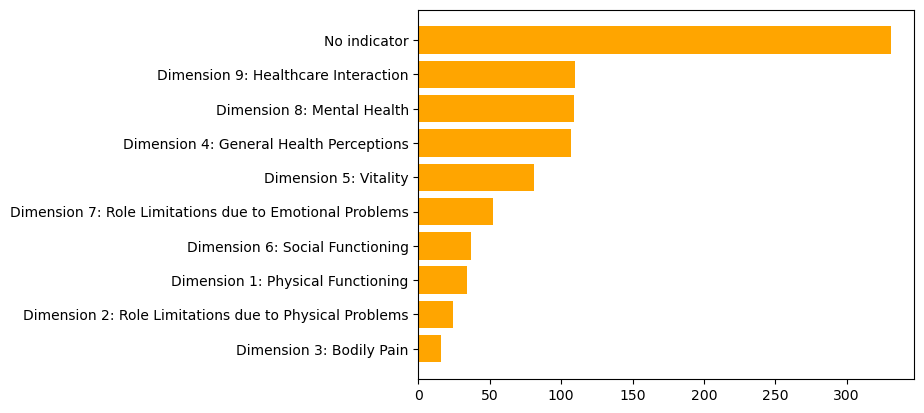

In [17]:
import matplotlib.pyplot as plt

# Contar la frecuencia de cada categoría
frecuencias = {dim: sum(data["dimension"] == dim) for dim in np.unique(data["dimension"])}

# Obtener las categorías y las frecuencias ordenadas decrecientemente
etiquetas = sorted(frecuencias.keys(), key=lambda x: frecuencias[x], reverse=False)
valores = [frecuencias[etiqueta] for etiqueta in etiquetas]

# Crear el gráfico de barras horizontales
plt.barh(etiquetas, valores, color="orange")

# Mostrar el gráfico
plt.show()

#### Correct class imbalance:

In [18]:
data_ind = data[data["dimension"] != "No indicator"]
data_no_ind = data[data["dimension"] == "No indicator"]

In [22]:
data_no_ind = data_no_ind.sample(100, random_state=123)

In [24]:
balanced_data = pd.concat([data_ind, data_no_ind], axis = 0).reset_index(drop = True)

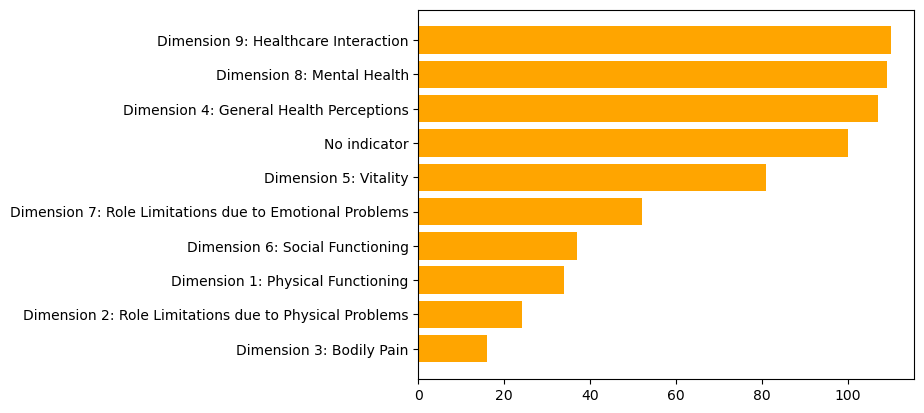

In [26]:
# Contar la frecuencia de cada categoría
frecuencias = {dim: sum(balanced_data["dimension"] == dim) for dim in np.unique(data["dimension"])}

# Obtener las categorías y las frecuencias ordenadas decrecientemente
etiquetas = sorted(frecuencias.keys(), key=lambda x: frecuencias[x], reverse=False)
valores = [frecuencias[etiqueta] for etiqueta in etiquetas]

# Crear el gráfico de barras horizontales
plt.barh(etiquetas, valores, color="orange")

# Mostrar el gráfico
plt.show()

#### Start the SparkNLP session:


In [28]:
spark = sparknlp.start()

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3089882f-64e8-4d83-906a-472c1c3fd4ad;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.0.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#fa

	[SUCCESSFUL ] com.google.http-client#google-http-client-gson;1.43.0!google-http-client-gson.jar (15ms)
downloading https://repo1.maven.org/maven2/com/google/api-client/google-api-client/2.2.0/google-api-client-2.2.0.jar ...
	[SUCCESSFUL ] com.google.api-client#google-api-client;2.2.0!google-api-client.jar (18ms)
downloading https://repo1.maven.org/maven2/commons-codec/commons-codec/1.15/commons-codec-1.15.jar ...
	[SUCCESSFUL ] commons-codec#commons-codec;1.15!commons-codec.jar (12ms)
downloading https://repo1.maven.org/maven2/com/google/oauth-client/google-oauth-client/1.34.1/google-oauth-client-1.34.1.jar ...
	[SUCCESSFUL ] com.google.oauth-client#google-oauth-client;1.34.1!google-oauth-client.jar (7ms)
downloading https://repo1.maven.org/maven2/com/google/http-client/google-http-client-apache-v2/1.43.0/google-http-client-apache-v2-1.43.0.jar ...
	[SUCCESSFUL ] com.google.http-client#google-http-client-apache-v2;1.43.0!google-http-client-apache-v2.jar (10ms)
downloading https://repo

	[SUCCESSFUL ] org.codehaus.mojo#animal-sniffer-annotations;1.22!animal-sniffer-annotations.jar (7ms)
downloading https://repo1.maven.org/maven2/io/opencensus/opencensus-proto/0.2.0/opencensus-proto-0.2.0.jar ...
	[SUCCESSFUL ] io.opencensus#opencensus-proto;0.2.0!opencensus-proto.jar (12ms)
downloading https://repo1.maven.org/maven2/io/grpc/grpc-services/1.53.0/grpc-services-1.53.0.jar ...
	[SUCCESSFUL ] io.grpc#grpc-services;1.53.0!grpc-services.jar (11ms)
downloading https://repo1.maven.org/maven2/com/google/re2j/re2j/1.6/re2j-1.6.jar ...
	[SUCCESSFUL ] com.google.re2j#re2j;1.6!re2j.jar (9ms)
downloading https://repo1.maven.org/maven2/io/grpc/grpc-netty-shaded/1.53.0/grpc-netty-shaded-1.53.0.jar ...
	[SUCCESSFUL ] io.grpc#grpc-netty-shaded;1.53.0!grpc-netty-shaded.jar (38ms)
downloading https://repo1.maven.org/maven2/io/grpc/grpc-googleapis/1.53.0/grpc-googleapis-1.53.0.jar ...
	[SUCCESSFUL ] io.grpc#grpc-googleapis;1.53.0!grpc-googleapis.jar (9ms)
downloading https://repo1.maven.or

23/07/08 17:01:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


#### Transform the pandas dataframes into spark dataframes:

In [29]:
# Definir el esquema manualmente
schema = StructType([
    StructField("frase_traducida", StringType(), nullable=True),
    StructField("dimension", StringType(), nullable=True)
])

# Suponiendo que "data" es tu DataFrame de pandas
rdd_data = spark.sparkContext.parallelize(balanced_data.values.tolist())

# Crear el DataFrame de Spark a partir del RDD y el esquema
frases = spark.createDataFrame(rdd_data, schema)

# Verificar que el DataFrame de Spark se ha creado correctamente
frases.show()

+--------------------+--------------------+
|     frase_traducida|           dimension|
+--------------------+--------------------+
|After studying ep...|Dimension 8: Ment...|
|that now I was a ...|Dimension 7: Role...|
|I have evolved to...|Dimension 7: Role...|
|I have evolved to...|Dimension 8: Ment...|
|I have evolved to...|Dimension 8: Ment...|
|I share my experi...|Dimension 6: Soci...|
|, And promote the...|Dimension 4: Gene...|
|I self -explore i...|Dimension 4: Gene...|
|For me my mind wa...|Dimension 8: Ment...|
|For me my mind wa...|Dimension 1: Phys...|
|that is, a separa...|Dimension 5: Vita...|
|that is to say th...|Dimension 9: Heal...|
|And starting to o...|Dimension 6: Soci...|
|This help is not ...|Dimension 9: Heal...|
|And you know that...|Dimension 9: Heal...|
|Because the same ...|Dimension 9: Heal...|
|To the doctor of ...|Dimension 4: Gene...|
|To the doctor of ...|Dimension 4: Gene...|
|And how to focus ...|Dimension 8: Ment...|
|On February 15, 2...|Dimension 

In [30]:
# Definir el esquema manualmente
schema = StructType([
    StructField("frase_traducida", StringType(), nullable=True),
    StructField("dimension", StringType(), nullable=True)
])

# Suponiendo que "data" es tu DataFrame de pandas
rdd_data = spark.sparkContext.parallelize(unseen.values.tolist())

# Crear el DataFrame de Spark a partir del RDD y el esquema
unseen = spark.createDataFrame(rdd_data, schema)

# Verificar que el DataFrame de Spark se ha creado correctamente
unseen.show()

+--------------------+--------------------+
|     frase_traducida|           dimension|
+--------------------+--------------------+
|It is not somethi...|Dimension 5: Vita...|
|thus to support o...|Dimension 6: Soci...|
|        And not fall|Dimension 5: Vita...|
|Because cancer to...|Dimension 5: Vita...|
|go ahead and have...|Dimension 2: Role...|
|Because here I ha...|Dimension 2: Role...|
|That is why I nev...|Dimension 9: Heal...|
|And the next day ...|Dimension 5: Vita...|
|“Hello, my name i...|        No indicator|
|10 years ago I wa...|Dimension 9: Heal...|
|Due to the tumor ...|        No indicator|
|I already recover...|Dimension 5: Vita...|
|In December last ...|Dimension 3: Bodi...|
|, but this time t...|Dimension 5: Vita...|
|I am currently in...|        No indicator|
|The recovery is s...|Dimension 5: Vita...|
|, and surely with...|Dimension 5: Vita...|
|, and surely with...|Dimension 8: Ment...|
|I want to thank n...|Dimension 8: Ment...|
|, and to all the ...|Dimension 

#### Dividing input data into train and test sets:

In [35]:
train, test = frases.randomSplit([0.8, 0.2], seed = 123)

## Bag of Words:

In [28]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('frase_traducida')\
  .setOutputCol('document')
docs = assembler.transform(frases)
docs.limit(5).toPandas()

# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['document'])\
  .setOutputCol('tokens')

# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(
  inputCol='filtered',
  outputCol='features'
)


# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer
   ])

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction', 
  outputCol = 'pred_label', 
  labels = label_indexer.labels)


results = []

def fit_model(model):
    # Construct the overall pipeline
    pipeline = Pipeline(
        stages=[
            text_processing_pipeline,
            label_indexer,
            model,
            prediction_deindexer
        ]
    )

    # Train the model
    model = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model.transform(train)
    test_predicted = model.transform(test)

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

import itertools

# Define the common options for featuresCol and labelCol
common_options = {
    'featuresCol': 'features',
    'labelCol': 'label'
}

# Define the hyperparameter options for each model
hyperparameter_options = {
    'NaiveBayes': {
        'smoothing': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'numTrees': [10, 20, 30],
        'maxDepth': [3, 5, 7]
    }
}

# Generate all combinations of hyperparameters for each model
model_list = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        model = eval(f"{model_name}(**model_params)")
        model_list.append(model)

# Create a list of dictionaries with model names and parameters
results = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        result = {
            'Model_name': model_name,
            'Parameters': model_params
        }
        results.append(result)

# Create the results DataFrame
bow_results = pd.concat([pd.DataFrame(model_list, columns=["Model"]), pd.DataFrame(results)], axis=1)

bow_results.head()

# Merge with the combinatios to form the desired output dataframe
metrics = pd.DataFrame()
for model in bow_results.Model:
    metrics = pd.concat([metrics, fit_model(model)], axis = 0)
    
bow_results = pd.concat([bow_results, metrics.reset_index(drop = True)], axis = 1, ignore_index=True)
new_column_names = {0: 'Model', 1: 'Model_name', 2: 'params', 3:'train_acc', 4:'train_rec', 5:'train_f1', 6:'test_acc', 7:'test_rec', 8:'test_f1'}
bow_results.rename(columns=new_column_names, inplace=True)

bow_results.head()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


23/07/05 09:04:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/05 09:04:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/07/05 09:04:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/07/05 09:04:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


,Model,Model_name,params,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1
0,NaiveBayes_84a803936e3b,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.860841,0.856881,0.855951,0.295018,0.328,0.304398
1,NaiveBayes_2a2bb14352b9,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.843804,0.834862,0.833466,0.289947,0.320,0.290962
2,NaiveBayes_488b759af2df,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.823760,0.807339,0.803186,0.276825,0.312,0.278944
3,LogisticRegression_037083dc523a,LogisticRegression,"{'featuresCol': 'features', 'labelCol': 'label...",0.940696,0.939450,0.939449,0.300865,0.304,0.297760
4,LogisticRegression_4ae3033a6934,LogisticRegression,"{'featuresCol': 'features', 'labelCol': 'label...",0.926780,0.921101,0.921526,0.293050,0.328,0.302544


In [30]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = bow_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'multiclass_bow_results_S3.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'XM7C9RKEZQ41VVES',
  'HostId': '+9b0Ysz3WQHnBQ4pWe8v+/9c34lOWqXKS8TmreXp8EGOAdqTzQoZ6YzVOamBWu/RIzilbmkJ+nM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+9b0Ysz3WQHnBQ4pWe8v+/9c34lOWqXKS8TmreXp8EGOAdqTzQoZ6YzVOamBWu/RIzilbmkJ+nM=',
   'x-amz-request-id': 'XM7C9RKEZQ41VVES',
   'date': 'Wed, 05 Jul 2023 09:06:12 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"ab0e61ee7d85fad8ed4499997e04b165"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"ab0e61ee7d85fad8ed4499997e04b165"',
 'ServerSideEncryption': 'AES256'}

# TF-IDF:

In [31]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('frase_traducida')\
  .setOutputCol('document')
docs = assembler.transform(frases)
docs.limit(5).toPandas()

# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['document'])\
  .setOutputCol('tokens')

# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

# Define count vectorizer
count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'tf'
  )

# Define TF-IDF
tfidf = IDF(
  inputCol = 'tf',
  outputCol = 'tfidf'
  )

# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    tfidf
   ])

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction', 
  outputCol = 'pred_label', 
  labels = label_indexer.labels)


results = []

def fit_model(model):
    # Construct the overall pipeline
    pipeline = Pipeline(
        stages=[
            text_processing_pipeline,
            label_indexer,
            model,
            prediction_deindexer
        ]
    )

    # Train the model
    model = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model.transform(train)
    test_predicted = model.transform(test)

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

import itertools

# Define the common options for featuresCol and labelCol
common_options = {
    'featuresCol': 'tfidf',
    'labelCol': 'label'
}

# Define the hyperparameter options for each model
hyperparameter_options = {
    'NaiveBayes': {
        'smoothing': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'numTrees': [10, 20, 30],
        'maxDepth': [3, 5, 7]
    }
}

# Generate all combinations of hyperparameters for each model
model_list = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        model = eval(f"{model_name}(**model_params)")
        model_list.append(model)

# Create a list of dictionaries with model names and parameters
results = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        result = {
            'Model_name': model_name,
            'Parameters': model_params
        }
        results.append(result)

# Create the results DataFrame
tfidf_results = pd.concat([pd.DataFrame(model_list, columns = ["Model"]), pd.DataFrame(results)], axis = 1)

tfidf_results.head()

# Merge with the combinatios to form the desired output dataframe
metrics = pd.DataFrame()
for model in tfidf_results.Model:
    metrics = pd.concat([metrics, fit_model(model)], axis = 0)
    
tfidf_results = pd.concat([tfidf_results, metrics.reset_index(drop = True)], axis = 1, ignore_index=True)
new_column_names = {0: 'Model', 1: 'Model_name', 2: 'params', 3:'train_acc', 4:'train_rec', 5:'train_f1', 6:'test_acc', 7:'test_rec', 8:'test_f1'}
tfidf_results.rename(columns=new_column_names, inplace=True)

tfidf_results.head()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


,Model,Model_name,params,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1
0,NaiveBayes_089aa45b8472,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.877547,0.875229,0.875160,0.310625,0.288,0.286216
1,NaiveBayes_b729fed2ba4b,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.877547,0.875229,0.875160,0.317595,0.320,0.306246
2,NaiveBayes_bd7593ec6a34,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.881790,0.880734,0.880669,0.326009,0.328,0.315834
3,LogisticRegression_c94f7c47d748,LogisticRegression,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.940696,0.939450,0.939449,0.300865,0.304,0.297760
4,LogisticRegression_00b92b302400,LogisticRegression,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.926780,0.921101,0.921526,0.293050,0.328,0.302544


In [33]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = tfidf_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'multiclass_tfidf_results_S3.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)


{'ResponseMetadata': {'RequestId': 'F2Q94CYT8BKPWXX9',
  'HostId': 'IALHpIVWqoalrYeNBIllLfo6+9PfydFeVSQhtShG0LL/dC8+JokGpexBQNAg3mvI+O6l2q67edg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'IALHpIVWqoalrYeNBIllLfo6+9PfydFeVSQhtShG0LL/dC8+JokGpexBQNAg3mvI+O6l2q67edg=',
   'x-amz-request-id': 'F2Q94CYT8BKPWXX9',
   'date': 'Wed, 05 Jul 2023 09:09:14 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"8d0c466bb8d1906486a7eaec4b8efa3d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"8d0c466bb8d1906486a7eaec4b8efa3d"',
 'ServerSideEncryption': 'AES256'}

# DEEP LEARNING APPROACH

In [28]:
pd.set_option('display.max_rows', None)

## GloVe

In [29]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

from pyspark.ml.feature import SQLTransformer

# Define the assemblertos
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the feature extractor using GloVe word embeddings
embeddings = WordEmbeddingsModel.pretrained(comb["model"], "en") \
    .setInputCols(["document", "cleanedToken"]) \
    .setOutputCol("embeddings")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'glove_100d': {
            'batchSize': [16, 8, 4, 2],
            'dropout': [0.1, 0.2],
            'lr': [0.001, 0.003, 0.005],
            'maxEpochs': [75]
    }
}

# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ / ]Download done! Loading the resource.
[OK!]


2023-07-06 11:43:03.352499: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/0f8ddd2b1293_classifier_dl2359891187734803445
2023-07-06 11:43:03.458897: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 11:43:03.458957: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/0f8ddd2b1293_classifier_dl2359891187734803445
2023-07-06 11:43:03.459037: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 11:43:03.989653: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
202

Training started - epochs: 75 - learning_rate: 0.001 - batch_size: 16 - training_examples: 545 - classes: 10
Epoch 1/75 - 0.65s - loss: 79.1724 - acc: 0.1875 - batches: 35
Epoch 2/75 - 0.20s - loss: 75.92915 - acc: 0.28125 - batches: 35
Epoch 3/75 - 0.25s - loss: 73.98646 - acc: 0.31985295 - batches: 35
Epoch 4/75 - 0.27s - loss: 73.00763 - acc: 0.34558824 - batches: 35
Epoch 5/75 - 0.23s - loss: 72.25513 - acc: 0.3658088 - batches: 35
Epoch 6/75 - 0.18s - loss: 71.812645 - acc: 0.3841912 - batches: 35
Epoch 7/75 - 0.18s - loss: 71.61634 - acc: 0.3915441 - batches: 35
Epoch 8/75 - 0.17s - loss: 71.475426 - acc: 0.3970588 - batches: 35
Epoch 9/75 - 0.18s - loss: 71.32999 - acc: 0.40808824 - batches: 35
Epoch 10/75 - 0.18s - loss: 71.1898 - acc: 0.4154412 - batches: 35
Epoch 11/75 - 0.19s - loss: 71.07097 - acc: 0.41911766 - batches: 35
Epoch 12/75 - 0.16s - loss: 70.956505 - acc: 0.42647058 - batches: 35
Epoch 13/75 - 0.17s - loss: 70.85419 - acc: 0.4283088 - batches: 35
Epoch 14/75 - 0

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


2023-07-06 11:43:39.561613: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/832582e4cca3_classifier_dl10412687163200568783
2023-07-06 11:43:39.651264: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 11:43:39.651314: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/832582e4cca3_classifier_dl10412687163200568783
2023-07-06 11:43:40.190658: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 11:43:41.309416: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/832582e4cca3_classifier_dl10412687163200568783
2023-07-06 11:43:41.513883: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1952282 microse

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 16 - training_examples: 545 - classes: 10
Epoch 1/75 - 0.53s - loss: 79.91798 - acc: 0.17830883 - batches: 35
Epoch 2/75 - 0.17s - loss: 78.67185 - acc: 0.2591912 - batches: 35
Epoch 3/75 - 0.20s - loss: 77.718834 - acc: 0.31433824 - batches: 35
Epoch 4/75 - 0.21s - loss: 76.58793 - acc: 0.4007353 - batches: 35
Epoch 5/75 - 0.21s - loss: 75.90448 - acc: 0.41911766 - batches: 35
Epoch 6/75 - 0.17s - loss: 75.20403 - acc: 0.4522059 - batches: 35
Epoch 7/75 - 0.17s - loss: 74.72778 - acc: 0.46875 - batches: 35
Epoch 8/75 - 0.17s - loss: 74.28256 - acc: 0.48161766 - batches: 35
Epoch 9/75 - 0.18s - loss: 73.96497 - acc: 0.48713234 - batches: 35
Epoch 10/75 - 0.16s - loss: 73.81322 - acc: 0.49264705 - batches: 35


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


Epoch 11/75 - 0.20s - loss: 73.721756 - acc: 0.5128676 - batches: 35
Epoch 12/75 - 0.19s - loss: 73.617676 - acc: 0.5147059 - batches: 35
Epoch 13/75 - 0.19s - loss: 73.53433 - acc: 0.5275735 - batches: 35
Epoch 14/75 - 0.24s - loss: 73.48156 - acc: 0.5294118 - batches: 35


KeyboardInterrupt: 

In [31]:
glove_results = dla_results
glove_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.311934,0.484404,0.377498,0.327086,0.448,0.369234,16,0.1,0.001,75,glove_100d
1,NaN,NaN,NaN,NaN,NaN,NaN,16,0.1,0.003,75,glove_100d
2,NaN,NaN,NaN,NaN,NaN,NaN,16,0.1,0.005,75,glove_100d
3,NaN,NaN,NaN,NaN,NaN,NaN,16,0.2,0.001,75,glove_100d
4,NaN,NaN,NaN,NaN,NaN,NaN,16,0.2,0.003,75,glove_100d


In [29]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = glove_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'multiclass_glove_results_balanced_S3_total.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': '401H52FFEGAVK4R6',
  'HostId': '+pOw2MVnYg0aIRg3ED+4oDEG6kzlq//MNGjazv2yWCzcKL6sobjWIVca9dAx/4Xvll9JWfKnAJc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+pOw2MVnYg0aIRg3ED+4oDEG6kzlq//MNGjazv2yWCzcKL6sobjWIVca9dAx/4Xvll9JWfKnAJc=',
   'x-amz-request-id': '401H52FFEGAVK4R6',
   'date': 'Wed, 05 Jul 2023 10:36:33 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"46d60bb71daca6b096ac35a3032deaef"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"46d60bb71daca6b096ac35a3032deaef"',
 'ServerSideEncryption': 'AES256'}

## BERT 

In [25]:
from pyspark.ml.feature import SQLTransformer

# Define the assemblertos
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the feature extractor using GloVe word embeddings
embeddings = BertEmbeddings.pretrained("bert_embeddings_bert_large_uncased_whole_word_masking", "en") \
  .setInputCols(["document", "cleanedToken"]) \
  .setOutputCol("embeddings")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'bert_embeddings_bert_large_uncased_whole_word_masking': {
            'batchSize': [16, 8, 4, 2],
            'dropout': [0.1, 0.2],
            'lr': [0.001, 0.003, 0.005],
            'maxEpochs': [75]
    }
}

# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]
bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[ | ]bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
Download done! Loading the resource.
[ \ ]

2023-07-06 21:09:07.591940: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ | ]

[OK!]


2023-07-06 21:10:57.041187: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/a5e4895dba8b_classifier_dl6200041373704469187
2023-07-06 21:10:57.099716: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:10:57.099794: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/a5e4895dba8b_classifier_dl6200041373704469187
2023-07-06 21:10:57.555666: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:10:58.617945: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/a5e4895dba8b_classifier_dl6200041373704469187
2023-07-06 21:10:58.882817: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1841664 microsecon

Training started - epochs: 75 - learning_rate: 0.001 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.05s - loss: 615.46985 - acc: 0.18933824 - batches: 273
Epoch 2/75 - 1.58s - loss: 574.2925 - acc: 0.3602941 - batches: 273
Epoch 3/75 - 1.62s - loss: 554.0529 - acc: 0.4466912 - batches: 273
Epoch 4/75 - 1.60s - loss: 544.7994 - acc: 0.4852941 - batches: 273
Epoch 5/75 - 1.56s - loss: 537.4583 - acc: 0.5110294 - batches: 273
Epoch 6/75 - 1.68s - loss: 531.36786 - acc: 0.5294118 - batches: 273
Epoch 7/75 - 1.69s - loss: 526.3554 - acc: 0.5422794 - batches: 273
Epoch 8/75 - 1.91s - loss: 522.05286 - acc: 0.5477941 - batches: 273
Epoch 9/75 - 1.50s - loss: 519.17535 - acc: 0.5606618 - batches: 273
Epoch 10/75 - 1.53s - loss: 516.974 - acc: 0.57169116 - batches: 273
Epoch 11/75 - 1.54s - loss: 514.99506 - acc: 0.5753676 - batches: 273
Epoch 12/75 - 1.67s - loss: 513.4463 - acc: 0.5808824 - batches: 273
Epoch 13/75 - 1.58s - loss: 512.31134 - acc: 0.5827206 - batches: 2

2023-07-06 21:17:16.401511: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/c5293da5f8cb_classifier_dl13350442025555388029
2023-07-06 21:17:16.488321: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:17:16.488379: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/c5293da5f8cb_classifier_dl13350442025555388029
2023-07-06 21:17:17.003495: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:17:18.057998: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/c5293da5f8cb_classifier_dl13350442025555388029
2023-07-06 21:17:18.315927: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1914425 microse

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.08s - loss: 630.2129 - acc: 0.16176471 - batches: 273
Epoch 2/75 - 1.50s - loss: 629.3612 - acc: 0.16544117 - batches: 273
Epoch 3/75 - 1.64s - loss: 629.3357 - acc: 0.16544117 - batches: 273
Epoch 4/75 - 1.82s - loss: 629.30457 - acc: 0.16544117 - batches: 273
Epoch 5/75 - 1.85s - loss: 629.2661 - acc: 0.16544117 - batches: 273
Epoch 6/75 - 1.84s - loss: 629.22156 - acc: 0.16544117 - batches: 273
Epoch 7/75 - 1.83s - loss: 629.17224 - acc: 0.16544117 - batches: 273
Epoch 8/75 - 1.47s - loss: 629.1219 - acc: 0.16544117 - batches: 273
Epoch 9/75 - 1.53s - loss: 629.07275 - acc: 0.16544117 - batches: 273
Epoch 10/75 - 1.56s - loss: 629.0266 - acc: 0.16544117 - batches: 273
Epoch 11/75 - 1.56s - loss: 628.9817 - acc: 0.16544117 - batches: 273
Epoch 12/75 - 1.54s - loss: 644.316 - acc: 0.1194853 - batches: 273
Epoch 13/75 - 1.52s - loss: 644.9279 - acc: 0.11764706 - ba

2023-07-06 21:23:44.267162: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/5c8c78acee39_classifier_dl8655563542970119605
2023-07-06 21:23:44.372802: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:23:44.372863: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/5c8c78acee39_classifier_dl8655563542970119605
2023-07-06 21:23:44.949837: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:23:46.155852: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/5c8c78acee39_classifier_dl8655563542970119605
2023-07-06 21:23:46.358379: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2091230 microsecon

Training started - epochs: 75 - learning_rate: 0.005 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.57s - loss: 625.6056 - acc: 0.16360295 - batches: 273
Epoch 2/75 - 1.73s - loss: 624.7483 - acc: 0.16544117 - batches: 273
Epoch 3/75 - 1.64s - loss: 618.7375 - acc: 0.15625 - batches: 273
Epoch 4/75 - 1.50s - loss: 636.7671 - acc: 0.11764706 - batches: 273
Epoch 5/75 - 1.68s - loss: 636.7987 - acc: 0.11764706 - batches: 273
Epoch 6/75 - 2.02s - loss: 636.8226 - acc: 0.11764706 - batches: 273
Epoch 7/75 - 2.47s - loss: 636.8389 - acc: 0.11764706 - batches: 273
Epoch 8/75 - 1.82s - loss: 636.8504 - acc: 0.11764706 - batches: 273
Epoch 9/75 - 1.61s - loss: 636.8587 - acc: 0.11764706 - batches: 273
Epoch 10/75 - 1.88s - loss: 636.8649 - acc: 0.11764706 - batches: 273
Epoch 11/75 - 2.15s - loss: 636.86975 - acc: 0.11764706 - batches: 273
Epoch 12/75 - 2.25s - loss: 636.87354 - acc: 0.11764706 - batches: 273
Epoch 13/75 - 2.02s - loss: 636.8766 - acc: 0.11764706 - batch

2023-07-06 21:30:40.117991: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/7ba8f0d307c0_classifier_dl562347915839015711
2023-07-06 21:30:40.232183: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:30:40.232242: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/7ba8f0d307c0_classifier_dl562347915839015711
2023-07-06 21:30:40.825126: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:30:42.039643: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/7ba8f0d307c0_classifier_dl562347915839015711
2023-07-06 21:30:42.246402: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2128421 microseconds.

Training started - epochs: 75 - learning_rate: 0.001 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.17s - loss: 608.5379 - acc: 0.20955883 - batches: 273
Epoch 2/75 - 1.55s - loss: 583.2345 - acc: 0.3216912 - batches: 273
Epoch 3/75 - 1.54s - loss: 566.6576 - acc: 0.3805147 - batches: 273
Epoch 4/75 - 1.69s - loss: 551.7942 - acc: 0.4632353 - batches: 273
Epoch 5/75 - 1.61s - loss: 540.79767 - acc: 0.5018382 - batches: 273
Epoch 6/75 - 1.56s - loss: 532.60803 - acc: 0.5294118 - batches: 273
Epoch 7/75 - 1.57s - loss: 526.4557 - acc: 0.5496324 - batches: 273
Epoch 8/75 - 1.56s - loss: 521.65204 - acc: 0.5643382 - batches: 273
Epoch 9/75 - 1.54s - loss: 517.6307 - acc: 0.5772059 - batches: 273
Epoch 10/75 - 1.54s - loss: 514.3418 - acc: 0.5900735 - batches: 273
Epoch 11/75 - 1.85s - loss: 511.57028 - acc: 0.5974265 - batches: 273
Epoch 12/75 - 1.65s - loss: 509.2305 - acc: 0.60294116 - batches: 273
Epoch 13/75 - 1.64s - loss: 507.1185 - acc: 0.6047794 - batches: 27

2023-07-06 21:36:56.155369: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/f6b4dd4a3957_classifier_dl7798688504431422232
2023-07-06 21:36:56.270805: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:36:56.270863: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/f6b4dd4a3957_classifier_dl7798688504431422232
2023-07-06 21:36:56.854914: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:36:57.944900: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/f6b4dd4a3957_classifier_dl7798688504431422232
2023-07-06 21:36:58.146556: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1991195 microsecon

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.11s - loss: 632.20337 - acc: 0.15808824 - batches: 273
Epoch 2/75 - 1.55s - loss: 632.3318 - acc: 0.15992647 - batches: 273
Epoch 3/75 - 1.50s - loss: 632.305 - acc: 0.15992647 - batches: 273
Epoch 4/75 - 1.56s - loss: 632.2806 - acc: 0.15992647 - batches: 273
Epoch 5/75 - 1.63s - loss: 632.2566 - acc: 0.15992647 - batches: 273
Epoch 6/75 - 1.68s - loss: 632.2338 - acc: 0.15992647 - batches: 273
Epoch 7/75 - 1.67s - loss: 632.21344 - acc: 0.15992647 - batches: 273
Epoch 8/75 - 1.67s - loss: 632.1945 - acc: 0.15992647 - batches: 273
Epoch 9/75 - 1.65s - loss: 632.17786 - acc: 0.15992647 - batches: 273
Epoch 10/75 - 1.76s - loss: 632.16327 - acc: 0.15992647 - batches: 273
Epoch 11/75 - 1.60s - loss: 632.1511 - acc: 0.15992647 - batches: 273
Epoch 12/75 - 1.58s - loss: 632.1412 - acc: 0.15992647 - batches: 273
Epoch 13/75 - 1.61s - loss: 632.13257 - acc: 0.15992647 - 

2023-07-06 21:43:19.679193: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/b93102cfd082_classifier_dl977605696749869799
2023-07-06 21:43:19.800179: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-06 21:43:19.800238: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/b93102cfd082_classifier_dl977605696749869799
2023-07-06 21:43:20.409523: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-06 21:43:21.539944: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/b93102cfd082_classifier_dl977605696749869799
2023-07-06 21:43:21.744994: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2065812 microseconds.

Training started - epochs: 75 - learning_rate: 0.005 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.20s - loss: 658.3861 - acc: 0.05514706 - batches: 273
Epoch 2/75 - 1.61s - loss: 658.5553 - acc: 0.056985293 - batches: 273
Epoch 3/75 - 1.57s - loss: 658.51666 - acc: 0.05882353 - batches: 273
Epoch 4/75 - 1.56s - loss: 660.3832 - acc: 0.06985294 - batches: 273
Epoch 5/75 - 1.57s - loss: 642.22504 - acc: 0.11764706 - batches: 273
Epoch 6/75 - 1.59s - loss: 642.12573 - acc: 0.11764706 - batches: 273
Epoch 7/75 - 1.62s - loss: 642.0576 - acc: 0.11764706 - batches: 273
Epoch 8/75 - 1.58s - loss: 642.0118 - acc: 0.11764706 - batches: 273
Epoch 9/75 - 1.57s - loss: 641.979 - acc: 0.11764706 - batches: 273
Epoch 10/75 - 1.56s - loss: 641.95734 - acc: 0.11764706 - batches: 273
Epoch 11/75 - 1.56s - loss: 641.94257 - acc: 0.11764706 - batches: 273
Epoch 12/75 - 1.51s - loss: 641.93207 - acc: 0.11764706 - batches: 273
Epoch 13/75 - 1.47s - loss: 641.92444 - acc: 0.11764706

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.662859,0.750459,0.698280,0.412344,0.424,0.410959,2,0.1,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
1,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...
2,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.005,75,bert_embeddings_bert_large_uncased_whole_word_...
3,0.528115,0.693578,0.596785,0.386132,0.448,0.412344,2,0.2,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
4,0.076357,0.273394,0.119193,0.072910,0.224,0.109257,2,0.2,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...


In [28]:
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.505946,0.664220,0.570814,0.386266,0.472,0.424158,16,0.1,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
1,0.526647,0.678899,0.588322,0.440110,0.472,0.442309,16,0.1,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...
2,0.087249,0.256881,0.123757,0.093497,0.280,0.139735,16,0.1,0.005,75,bert_embeddings_bert_large_uncased_whole_word_...
3,0.390126,0.577982,0.458541,0.345742,0.480,0.398117,16,0.2,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
4,0.514237,0.671560,0.579953,0.413541,0.480,0.440782,16,0.2,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...


In [28]:
bert_results = dla_results
bert_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
3,0.528115,0.693578,0.596785,0.386132,0.448,0.412344,2,0.2,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
0,0.662859,0.750459,0.698280,0.412344,0.424,0.410959,2,0.1,0.001,75,bert_embeddings_bert_large_uncased_whole_word_...
4,0.076357,0.273394,0.119193,0.072910,0.224,0.109257,2,0.2,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...
1,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.003,75,bert_embeddings_bert_large_uncased_whole_word_...
2,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.005,75,bert_embeddings_bert_large_uncased_whole_word_...


In [29]:
# Convertir el DataFrame a formato CSV en memoria
csv_buffer = bert_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'multiclass_bert_results_balanced_S3_total(2).csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'ZJDWBVDTNRHHK3AF',
  'HostId': 'xOH8CCkYlIxm6Kca6X6rt5tZiS9yedJ5t4nBijMSnEIrH1puWT46oBo/dZmvkMRSUdu7SOLWTxT/vZhZDDX9lOXPUSsKk4PT',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'xOH8CCkYlIxm6Kca6X6rt5tZiS9yedJ5t4nBijMSnEIrH1puWT46oBo/dZmvkMRSUdu7SOLWTxT/vZhZDDX9lOXPUSsKk4PT',
   'x-amz-request-id': 'ZJDWBVDTNRHHK3AF',
   'date': 'Thu, 06 Jul 2023 22:49:44 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"b7412f5d0bd19a18630b4f26dae09ec0"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b7412f5d0bd19a18630b4f26dae09ec0"',
 'ServerSideEncryption': 'AES256'}

## BIO-RoBERTa

In [27]:
from pyspark.ml.feature import SQLTransformer

# Define the assemblertos
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the feature extractor using BIO-RoBERTa word embeddings
    embeddings = RoBertaEmbeddings.pretrained("roberta_embeddings_pmc_med_bio_mlm_roberta_large", "en") \
      .setInputCols(["document", "cleanedToken"]) \
      .setOutputCol("embeddings")
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'roberta_embeddings_pmc_med_bio_mlm_roberta_large': {
            'batchSize': [2],
            'dropout': [0.1, 0.2],
            'lr': [0.001, 0.003, 0.005],
            'maxEpochs': [75]
    }
}

# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]


roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[ | ]roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
Download done! Loading the resource.
[ / ]

[ — ]

2023-07-07 08:56:57.233233: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ \ ]

[OK!]


2023-07-07 08:59:19.073374: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/ceb040b5988e_classifier_dl3647081373910242034
2023-07-07 08:59:19.132715: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 08:59:19.132791: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/ceb040b5988e_classifier_dl3647081373910242034
2023-07-07 08:59:19.616147: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 08:59:20.792672: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/ceb040b5988e_classifier_dl3647081373910242034
2023-07-07 08:59:20.977249: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1903878 microsecon

Training started - epochs: 75 - learning_rate: 0.001 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.28s - loss: 620.1989 - acc: 0.15808824 - batches: 273
Epoch 2/75 - 1.56s - loss: 599.6686 - acc: 0.21691176 - batches: 273
Epoch 3/75 - 1.60s - loss: 589.63165 - acc: 0.28308824 - batches: 273
Epoch 4/75 - 1.59s - loss: 584.35657 - acc: 0.31066176 - batches: 273
Epoch 5/75 - 1.57s - loss: 578.7504 - acc: 0.32352942 - batches: 273
Epoch 6/75 - 1.75s - loss: 573.7894 - acc: 0.34191176 - batches: 273
Epoch 7/75 - 1.54s - loss: 569.34827 - acc: 0.3529412 - batches: 273
Epoch 8/75 - 1.60s - loss: 565.33466 - acc: 0.37132353 - batches: 273
Epoch 9/75 - 1.62s - loss: 561.88275 - acc: 0.3897059 - batches: 273
Epoch 10/75 - 1.55s - loss: 558.93536 - acc: 0.4007353 - batches: 273
Epoch 11/75 - 1.50s - loss: 556.15 - acc: 0.41360295 - batches: 273
Epoch 12/75 - 1.66s - loss: 553.4566 - acc: 0.4375 - batches: 273
Epoch 13/75 - 1.51s - loss: 550.78564 - acc: 0.4522059 - batches

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 09:07:18.135936: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/b3c1ff0c37b2_classifier_dl4754800411198449189
2023-07-07 09:07:18.226970: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 09:07:18.227033: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/b3c1ff0c37b2_classifier_dl4754800411198449189
2023-07-07 09:07:18.770131: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 09:07:19.929659: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/b3c1ff0c37b2_classifier_dl4754800411198449189
2023-07-07 09:07:20.157637: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2021712 microsecon

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.22s - loss: 626.4458 - acc: 0.16360295 - batches: 273
Epoch 2/75 - 1.70s - loss: 626.36566 - acc: 0.16544117 - batches: 273
Epoch 3/75 - 1.83s - loss: 626.33636 - acc: 0.16544117 - batches: 273
Epoch 4/75 - 1.70s - loss: 626.2968 - acc: 0.16544117 - batches: 273
Epoch 5/75 - 1.62s - loss: 626.2449 - acc: 0.16544117 - batches: 273
Epoch 6/75 - 1.53s - loss: 626.18475 - acc: 0.16544117 - batches: 273
Epoch 7/75 - 1.53s - loss: 626.12463 - acc: 0.16544117 - batches: 273
Epoch 8/75 - 1.65s - loss: 626.0699 - acc: 0.16544117 - batches: 273
Epoch 9/75 - 1.75s - loss: 626.0226 - acc: 0.16544117 - batches: 273
Epoch 10/75 - 1.61s - loss: 625.98364 - acc: 0.16544117 - batches: 273
Epoch 11/75 - 1.54s - loss: 625.88025 - acc: 0.16360295 - batches: 273
Epoch 12/75 - 1.76s - loss: 625.9063 - acc: 0.16544117 - batches: 273
Epoch 13/75 - 1.85s - loss: 625.899 - acc: 0.16544117 -

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 09:15:12.270534: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/64eba6b54e4b_classifier_dl7262218714808394800
2023-07-07 09:15:12.377312: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 09:15:12.377362: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/64eba6b54e4b_classifier_dl7262218714808394800
2023-07-07 09:15:12.956083: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 09:15:14.170422: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/64eba6b54e4b_classifier_dl7262218714808394800
2023-07-07 09:15:14.380041: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2109521 microsecon

Training started - epochs: 75 - learning_rate: 0.005 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.23s - loss: 636.4287 - acc: 0.14154412 - batches: 273
Epoch 2/75 - 1.76s - loss: 646.1121 - acc: 0.11580882 - batches: 273
Epoch 3/75 - 1.76s - loss: 645.31415 - acc: 0.11764706 - batches: 273
Epoch 4/75 - 1.70s - loss: 645.2296 - acc: 0.11764706 - batches: 273
Epoch 5/75 - 1.71s - loss: 645.1354 - acc: 0.11764706 - batches: 273
Epoch 6/75 - 1.79s - loss: 645.0508 - acc: 0.11764706 - batches: 273
Epoch 7/75 - 2.33s - loss: 644.98895 - acc: 0.11764706 - batches: 273
Epoch 8/75 - 1.95s - loss: 644.9459 - acc: 0.11764706 - batches: 273
Epoch 9/75 - 1.76s - loss: 644.9209 - acc: 0.11764706 - batches: 273
Epoch 10/75 - 1.76s - loss: 644.9076 - acc: 0.11764706 - batches: 273
Epoch 11/75 - 1.80s - loss: 644.90027 - acc: 0.11764706 - batches: 273
Epoch 12/75 - 1.81s - loss: 644.89636 - acc: 0.11764706 - batches: 273
Epoch 13/75 - 1.88s - loss: 644.8944 - acc: 0.11764706 - 

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 09:23:19.011930: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/e8c825ce8e3b_classifier_dl13916192684852090418
2023-07-07 09:23:19.127587: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 09:23:19.127646: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/e8c825ce8e3b_classifier_dl13916192684852090418
2023-07-07 09:23:19.716416: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 09:23:20.863814: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/e8c825ce8e3b_classifier_dl13916192684852090418
2023-07-07 09:23:21.100283: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2088367 microse

Training started - epochs: 75 - learning_rate: 0.001 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.22s - loss: 632.8579 - acc: 0.15992647 - batches: 273
Epoch 2/75 - 1.61s - loss: 631.7197 - acc: 0.16176471 - batches: 273
Epoch 3/75 - 1.65s - loss: 631.7178 - acc: 0.16176471 - batches: 273
Epoch 4/75 - 1.68s - loss: 631.71594 - acc: 0.16176471 - batches: 273
Epoch 5/75 - 1.68s - loss: 631.7142 - acc: 0.16176471 - batches: 273
Epoch 6/75 - 1.68s - loss: 631.71246 - acc: 0.16176471 - batches: 273
Epoch 7/75 - 1.65s - loss: 631.7107 - acc: 0.16176471 - batches: 273
Epoch 8/75 - 1.67s - loss: 631.709 - acc: 0.16176471 - batches: 273
Epoch 9/75 - 1.65s - loss: 631.7073 - acc: 0.16176471 - batches: 273
Epoch 10/75 - 1.65s - loss: 631.7055 - acc: 0.16176471 - batches: 273
Epoch 11/75 - 1.70s - loss: 631.7037 - acc: 0.16176471 - batches: 273
Epoch 12/75 - 1.70s - loss: 631.70184 - acc: 0.16176471 - batches: 273
Epoch 13/75 - 1.69s - loss: 631.7 - acc: 0.16176471 - batch

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 09:31:09.066981: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/52a3d91100fd_classifier_dl6597725289070413902
2023-07-07 09:31:09.189297: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 09:31:09.189355: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/52a3d91100fd_classifier_dl6597725289070413902
2023-07-07 09:31:09.806228: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 09:31:10.962426: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/52a3d91100fd_classifier_dl6597725289070413902
2023-07-07 09:31:11.260141: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2193170 microsecon

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 1.89s - loss: 650.9654 - acc: 0.113970585 - batches: 273
Epoch 2/75 - 1.44s - loss: 649.90186 - acc: 0.11764706 - batches: 273
Epoch 3/75 - 1.48s - loss: 649.6612 - acc: 0.11764706 - batches: 273
Epoch 4/75 - 1.50s - loss: 649.36835 - acc: 0.11764706 - batches: 273
Epoch 5/75 - 1.48s - loss: 649.1236 - acc: 0.11764706 - batches: 273
Epoch 6/75 - 1.45s - loss: 649.0114 - acc: 0.11764706 - batches: 273
Epoch 7/75 - 1.45s - loss: 648.96674 - acc: 0.11764706 - batches: 273
Epoch 8/75 - 1.47s - loss: 648.9451 - acc: 0.11764706 - batches: 273
Epoch 9/75 - 1.45s - loss: 648.93225 - acc: 0.11764706 - batches: 273
Epoch 10/75 - 1.48s - loss: 648.924 - acc: 0.11764706 - batches: 273
Epoch 11/75 - 1.48s - loss: 648.9183 - acc: 0.11764706 - batches: 273
Epoch 12/75 - 1.47s - loss: 648.91406 - acc: 0.11764706 - batches: 273
Epoch 13/75 - 1.44s - loss: 648.9109 - acc: 0.11764706 -

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 09:38:42.224852: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/89cfd4e6ee80_classifier_dl3932783112314893669
2023-07-07 09:38:42.350746: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 09:38:42.350799: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/89cfd4e6ee80_classifier_dl3932783112314893669
2023-07-07 09:38:42.972671: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 09:38:44.080377: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/89cfd4e6ee80_classifier_dl3932783112314893669
2023-07-07 09:38:44.320502: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2095661 microsecon

Training started - epochs: 75 - learning_rate: 0.005 - batch_size: 2 - training_examples: 545 - classes: 10
Epoch 1/75 - 2.37s - loss: 636.36053 - acc: 0.13970588 - batches: 273
Epoch 2/75 - 1.67s - loss: 635.40497 - acc: 0.1452206 - batches: 273
Epoch 3/75 - 1.70s - loss: 635.357 - acc: 0.1452206 - batches: 273
Epoch 4/75 - 1.68s - loss: 635.2702 - acc: 0.1452206 - batches: 273
Epoch 5/75 - 1.70s - loss: 635.15076 - acc: 0.14705883 - batches: 273
Epoch 6/75 - 1.71s - loss: 635.0718 - acc: 0.14705883 - batches: 273
Epoch 7/75 - 1.69s - loss: 635.01373 - acc: 0.14705883 - batches: 273
Epoch 8/75 - 1.78s - loss: 635.0428 - acc: 0.14705883 - batches: 273
Epoch 9/75 - 1.63s - loss: 634.9654 - acc: 0.14705883 - batches: 273
Epoch 10/75 - 1.66s - loss: 634.941 - acc: 0.14705883 - batches: 273
Epoch 11/75 - 1.67s - loss: 634.9252 - acc: 0.14705883 - batches: 273
Epoch 12/75 - 1.71s - loss: 634.91675 - acc: 0.14705883 - batches: 273
Epoch 13/75 - 1.60s - loss: 634.911 - acc: 0.14705883 - batch

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.394392,0.585321,0.463642,0.341679,0.432,0.372860,2,0.1,0.001,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
1,0.076987,0.258716,0.117930,0.062356,0.200,0.094044,2,0.1,0.003,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
2,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.005,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
3,0.067186,0.238532,0.104335,0.052172,0.184,0.080051,2,0.2,0.001,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
4,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.2,0.003,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large


In [30]:
BIOroBERTa_results = dla_results
BIOroBERTa_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.394392,0.585321,0.463642,0.341679,0.432,0.372860,2,0.1,0.001,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
1,0.076987,0.258716,0.117930,0.062356,0.200,0.094044,2,0.1,0.003,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
3,0.067186,0.238532,0.104335,0.052172,0.184,0.080051,2,0.2,0.001,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
2,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.1,0.005,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large
4,0.013790,0.117431,0.024682,0.018496,0.136,0.032563,2,0.2,0.003,75,roberta_embeddings_pmc_med_bio_mlm_roberta_large


In [31]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = BIOroBERTa_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'multiclass_BIOroBERTa_results_balanced_S3_total(2).csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'XSNMDH6RPQBJA7VP',
  'HostId': '51eCNhUNA27m+Uhd5LHxheOCfiXacNCkD7I5sZEvqzcaQhzIxaDagr6ktRdjA1c1xyCao8Je3Ho=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '51eCNhUNA27m+Uhd5LHxheOCfiXacNCkD7I5sZEvqzcaQhzIxaDagr6ktRdjA1c1xyCao8Je3Ho=',
   'x-amz-request-id': 'XSNMDH6RPQBJA7VP',
   'date': 'Fri, 07 Jul 2023 11:14:20 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"e60ecb5f0839fdb91cc8a807f7f0df09"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"e60ecb5f0839fdb91cc8a807f7f0df09"',
 'ServerSideEncryption': 'AES256'}

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

## Retraining the best model:

In [49]:
from pyspark.ml.feature import SQLTransformer

# Define the assemblertos
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the feature extractor using BERT word embeddings
embeddings = BertEmbeddings.pretrained("bert_embeddings_bert_large_uncased_whole_word_masking", "en") \
  .setInputCols(["document", "cleanedToken"]) \
  .setOutputCol("embeddings")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'dimension', 
  outputCol = 'label').fit(frases)

    
# Create the text classifier using ClassifierDLApproach.
classifier_dl = ClassifierDLApproach() \
  .setInputCols(['sentence_embeddings']) \
  .setOutputCol('prediction') \
  .setLabelColumn('label') \
  .setBatchSize(4) \
  .setMaxEpochs(75) \
  .setLr(0.003) \
  .setDropout(0.1) \
  .setEnableOutputLogs(True)

# Creating the pipeline
pipeline = Pipeline(stages=[
  document_assembler,
  tokenizer,
  stops,
  embeddings,
  sentence_embeddings,
  label_indexer,
  classifier_dl
])
    
# Train the model
model_pipeline = pipeline.fit(frases)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-08 17:40:03.398128: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/caf6e4584abc_classifier_dl1381250052577251039
2023-07-08 17:40:03.504995: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-08 17:40:03.505051: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/caf6e4584abc_classifier_dl1381250052577251039
2023-07-08 17:40:04.200945: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-08 17:40:05.420681: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/caf6e4584abc_classifier_dl1381250052577251039
2023-07-08 17:40:05.633691: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2235577 microsecon

Training started - epochs: 75 - learning_rate: 0.003 - batch_size: 4 - training_examples: 670 - classes: 10
Epoch 1/75 - 1.53s - loss: 389.23373 - acc: 0.15718563 - batches: 168
Epoch 2/75 - 1.10s - loss: 389.47327 - acc: 0.16017964 - batches: 168
Epoch 3/75 - 1.30s - loss: 390.12424 - acc: 0.14371258 - batches: 168
Epoch 4/75 - 1.21s - loss: 366.64404 - acc: 0.26796407 - batches: 168
Epoch 5/75 - 1.29s - loss: 341.10928 - acc: 0.39820358 - batches: 168
Epoch 6/75 - 1.16s - loss: 331.89474 - acc: 0.45808384 - batches: 168
Epoch 7/75 - 1.00s - loss: 325.50327 - acc: 0.50898206 - batches: 168
Epoch 8/75 - 1.18s - loss: 320.42523 - acc: 0.5299401 - batches: 168
Epoch 9/75 - 1.08s - loss: 316.2783 - acc: 0.56287426 - batches: 168
Epoch 10/75 - 1.09s - loss: 313.83 - acc: 0.58532935 - batches: 168
Epoch 11/75 - 1.09s - loss: 310.37216 - acc: 0.6152695 - batches: 168
Epoch 12/75 - 1.07s - loss: 307.99628 - acc: 0.63023955 - batches: 168
Epoch 13/75 - 1.12s - loss: 306.49936 - acc: 0.63922155

In [50]:
# Make predictions on the train and test sets
train_predicted = model_pipeline.transform(frases).selectExpr("label", "double(prediction.result[0]) as prediction")
test_predicted = model_pipeline.transform(unseen).selectExpr("label", "double(prediction.result[0]) as prediction")

In [51]:
# Initialize the evaluators
evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# Calculate precision, recall, and F1 score on the train set
train_precision = evaluator_precision.evaluate(train_predicted)
train_recall = evaluator_recall.evaluate(train_predicted)
train_f1 = evaluator_f1.evaluate(train_predicted)

# Calculate precision, recall, and F1 score on the test set
test_precision = evaluator_precision.evaluate(test_predicted)
test_recall = evaluator_recall.evaluate(test_predicted)
test_f1 = evaluator_f1.evaluate(test_predicted)

In [52]:
# Create a dictionary with the results
result = {
    'Train Precision': train_precision,
    'Train Recall': train_recall,
    'Train F1 Score': train_f1,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}
# Calculate confusion matrix for test set
y_true = test_predicted.select("label").toPandas()
y_pred = test_predicted.select("prediction").toPandas()

# Invertir los valores de la columna
y_true['label'] = y_true['label']
y_pred['prediction'] = y_pred['prediction']

result = pd.DataFrame(result, index=[0])

### Results:

In [53]:
result

,Train Precision,Train Recall,Train F1 Score,Test Precision,Test Recall,Test F1 Score
0,0.541773,0.685075,0.59991,0.362874,0.431373,0.385338


### Confusion Matrix:

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_true, y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix_test)

In [55]:
confusion_matrix_df

,0,1,2,3,4,5,6,7,8,9
0,5,0,1,0,0,0,0,0,0,0
1,3,4,2,1,4,0,0,0,0,0
2,3,0,2,0,2,0,0,0,0,0
3,1,1,0,24,0,0,0,0,0,0
4,6,4,2,1,9,0,0,0,0,0
5,0,4,2,0,3,0,0,0,0,0
6,1,3,4,0,1,0,0,0,0,0
7,1,0,0,0,1,0,0,0,0,0
8,0,0,2,0,1,0,0,0,0,0
9,0,1,0,2,1,0,0,0,0,0


In [56]:
diccionario = {i: valor for i, valor in enumerate(label_indexer.labels)}

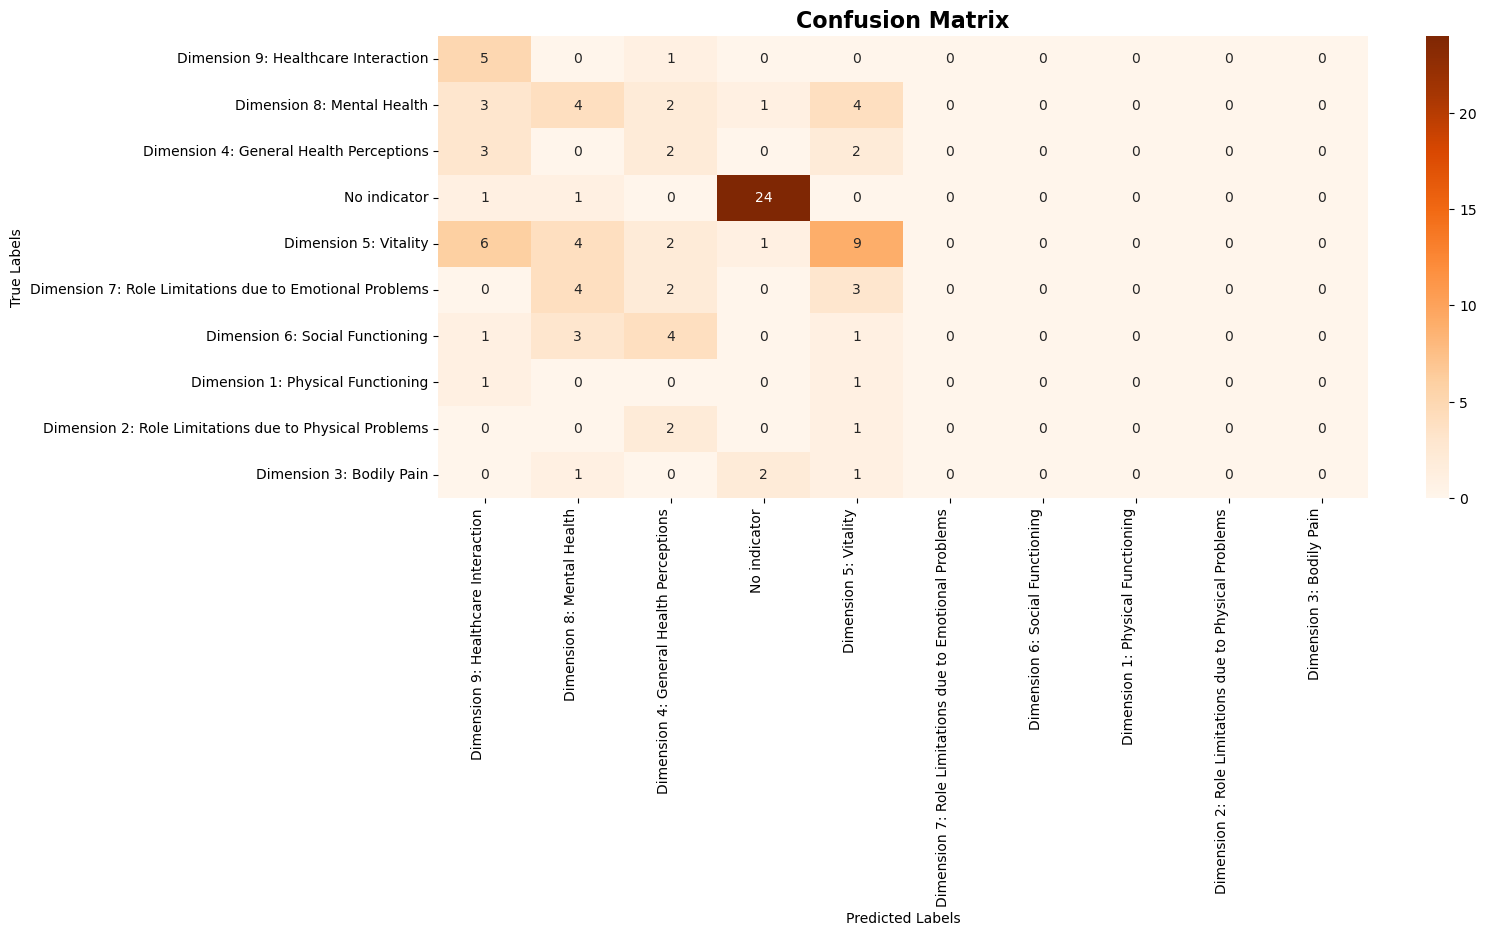

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generar un plot de heatmap de la matriz de confusión
plt.figure(figsize=(15, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Cambiar los labels en el eje x
plt.xticks(ticks=[i + 0.5 for i in range(len(diccionario))],
           labels=[diccionario[label] for label in confusion_matrix_df.columns],
           rotation=90, ha='right')

# Cambiar los labels en el eje y
plt.yticks(ticks=[i + 0.5 for i in range(len(diccionario))],
           labels=[diccionario[label] for label in confusion_matrix_df.index],
           rotation=0)

plt.show()


### Example predictions:

In [59]:
diccionario = {i: valor for i, valor in enumerate(label_indexer.labels)}

In [60]:
muestra_df = pd.concat([unseen_orig.frase, y_true, y_pred], axis = 1)
muestra_df.columns = ['Testimony phrase', 'Indicator Dimension', 'Prediction']

In [61]:
muestra_df['Indicator Dimension'] = muestra_df['Indicator Dimension'].map(diccionario)
muestra_df['Prediction'] = muestra_df['Prediction'].map(diccionario)

In [63]:
muestra_df[6:15].reset_index(drop = True)

,Testimony phrase,Indicator Dimension,Prediction
0,por ello nunca deje de trabajar yo siempre est...,Dimension 9: Healthcare Interaction,Dimension 4: General Health Perceptions
1,y al siguiente día iba a trabajar y ese es mi ...,Dimension 5: Vitality,Dimension 5: Vitality
2,"“Hola, me llamo Marta y tengo 16 años.",No indicator,No indicator
3,Hace 10 años me diagnosticaron un tumor en mi ...,Dimension 9: Healthcare Interaction,Dimension 9: Healthcare Interaction
4,Debido al tumor estuve todo el año ingresada y...,No indicator,No indicator
5,"De eso ya me recuperé, rehice mi vida y volví ...",Dimension 5: Vitality,Dimension 5: Vitality
6,En diciembre del año pasado me volvió a salir ...,Dimension 3: Bodily Pain,Dimension 8: Mental Health
7,", pero esta vez los traumatólogos han podido s...",Dimension 5: Vitality,Dimension 9: Healthcare Interaction
8,Actualmente estoy en tratamiento con quimio.,No indicator,No indicator
